<a href="https://colab.research.google.com/github/J0n4ta/Transfer-learning-curso-DIO/blob/main/Transfer_Learnig_com_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [3]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip -d PetImages

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: PetImages/PetImages/Dog/5500.jpg  
  inflating: PetImages/PetImages/Dog/5501.jpg  
  inflating: PetImages/PetImages/Dog/5502.jpg  
  inflating: PetImages/PetImages/Dog/5503.jpg  
  inflating: PetImages/PetImages/Dog/5504.jpg  
  inflating: PetImages/PetImages/Dog/5505.jpg  
  inflating: PetImages/PetImages/Dog/5506.jpg  
  inflating: PetImages/PetImages/Dog/5507.jpg  
  inflating: PetImages/PetImages/Dog/5508.jpg  
  inflating: PetImages/PetImages/Dog/5509.jpg  
  inflating: PetImages/PetImages/Dog/551.jpg  
  inflating: PetImages/PetImages/Dog/5510.jpg  
  inflating: PetImages/PetImages/Dog/5511.jpg  
  inflating: PetImages/PetImages/Dog/5512.jpg  
  inflating: PetImages/PetImages/Dog/5513.jpg  
  inflating: PetImages/PetImages/Dog/5514.jpg  
  inflating: PetImages/PetImages/Dog/5515.jpg  
  inflating: PetImages/PetImages/Dog/5516.jpg  
  inflating: PetImages/PetImages/Dog/5517.jpg  
  inflating: PetImages/PetImag

# **Removendo arquivos corrompidos**
Algumas imagens podem estar corrompidas deacordo com a extração do dataset. Logo, para melhorar o projeto sem contribuir para o erro, foi necessário remover algumas imagens não não seram usadas

In [4]:
import os
from PIL import Image

dataset_path = "/content/PetImages/PetImages"

for folder in ["Cat", "Dog"]:
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path)
            img.verify()  # Verifica se a imagem está corrompida
        except (IOError, SyntaxError):
            print(f"Removendo arquivo corrompido: {file_path}")
            os.remove(file_path)

Removendo arquivo corrompido: /content/PetImages/PetImages/Cat/Thumbs.db
Removendo arquivo corrompido: /content/PetImages/PetImages/Cat/666.jpg
Removendo arquivo corrompido: /content/PetImages/PetImages/Dog/Thumbs.db
Removendo arquivo corrompido: /content/PetImages/PetImages/Dog/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_path = "/content/PetImages/PetImages"

# Transformações para treino e teste
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carregar dataset
train_data = datasets.ImageFolder(dataset_path, transform=train_transform)
test_data = datasets.ImageFolder(dataset_path, transform=test_transform)

# Dividir o treino em (80%) e teste em (20%)
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

# Criar DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
import torch.nn as nn
from torchvision import models

# Carregar modelo pré-treinado
model = models.resnet18(pretrained=True)

# Congelar todas as camadas menos a última
for param in model.parameters():
    param.requires_grad = False

# Substituir a última camada para 2 classes (gato e cachorro)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Será gato quando for (0) e cachorro quando for (1)

# Mover modelo para GPU (Já que meu notebook talvez não rode)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Apenas otimiza a última camada

# Função de treino
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer, epochs=5)

Epoch 1/5, Loss: 0.1244640644915402
Epoch 2/5, Loss: 0.08054372245818377
Epoch 3/5, Loss: 0.07859502286836505
Epoch 4/5, Loss: 0.0734476161569357
Epoch 5/5, Loss: 0.07602661768272519


In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Acurácia no Teste: {accuracy:.2f}%")

evaluate_model(model, test_loader)

Acurácia no Teste: 98.12%


In [18]:
def predict_image(image_path, model, transform):
    # Carregar a imagem
    image = Image.open(image_path).convert('RGB') # Garante 3 canais de cor (RGB)

    # Aplicar as transformações
    image = transform(image)

    # Adicionar uma dimensão de batch (necessário para o modelo)
    image = image.unsqueeze(0)

    # Mover a imagem para o mesmo dispositivo do modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    # Fazer a predição
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)

    # Mapear a predição para o nome da classe
    class_names = ["Cat", "Dog"]
    prediction = class_names[predicted.item()]

    return prediction

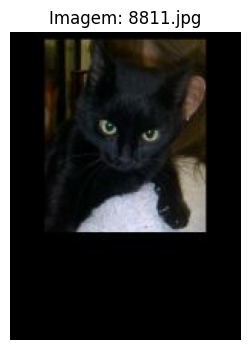

Predição do modelo: Cat
Pasta real: Cat


In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import torch

# Definir caminho base
base_path = "/content/PetImages/PetImages"

# Escolher aleatoriamente entre "Cat" e "Dog"
random_folder = random.choice(["Cat", "Dog"])

# Pegar uma imagem aleatória
test_image_path = random.choice([
    os.path.join(base_path, random_folder, f)
    for f in os.listdir(os.path.join(base_path, random_folder))
    if f.endswith(('.jpg', '.jpeg', '.png'))
])

# Mostrando a imagem
img = Image.open(test_image_path)
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')  # Removendo os eixos
plt.title(f"Imagem: {os.path.basename(test_image_path)}")
plt.show()

# Fazendo Predição
prediction = predict_image(test_image_path, model, test_transform)
print(f"Predição do modelo: {prediction}")
print(f"Pasta real: {random_folder}")  # Linha para comparar com o resultado

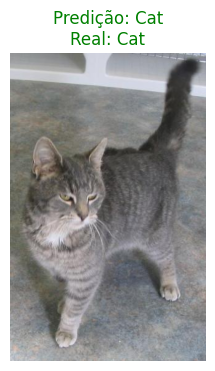

---


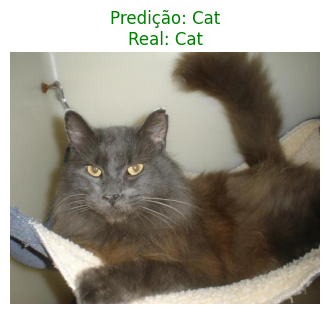

---


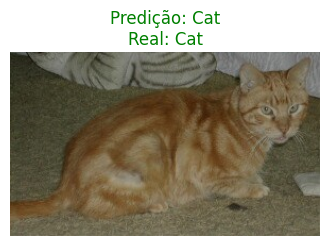

---


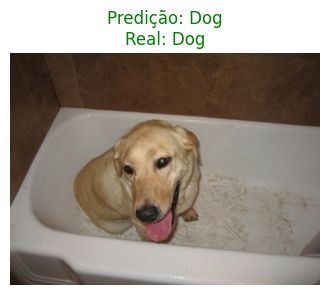

---


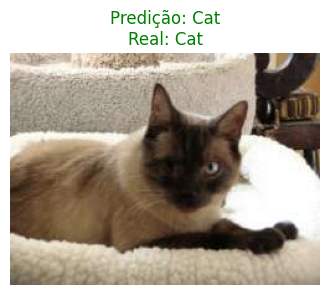

---


In [20]:
for _ in range(5):
    random_folder = random.choice(["Cat", "Dog"])
    test_image_path = random.choice([
        os.path.join(base_path, random_folder, f)
        for f in os.listdir(os.path.join(base_path, random_folder))
        if f.endswith(('.jpg', '.jpeg', '.png'))
    ])

    img = Image.open(test_image_path)
    prediction = predict_image(test_image_path, model, test_transform)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predição: {prediction}\nReal: {random_folder}",
              color='green' if prediction.lower() == random_folder.lower() else 'red')
    plt.show()
    print("---")